## A Quick Overview of Pandas for Cheminformatics
This notebook provides an overview of the Pandas library for data handling and manipulation in Python scripts.

Install the necessary Python libraries

In [1]:
# !pip install pandas numpy seaborn 

Import the necessary Python libraries

In [2]:
import pandas as pd
import numpy as np

Enable the display of plots from Pandas in a Jupyter notebook

In [3]:
%matplotlib inline

### Reading Data From and SD File
Read in a file containing data from hERG assays in the ChEMBL database

In [5]:
df = pd.read_csv("../data/ChEMBL_hERG.csv")

Examine the number of rows and columns in the dataframe

In [7]:
df.shape

(8989, 13)

### Getting an Overview of the Data
We can also look at datatype for each of the columns

In [8]:
df.dtypes

canonical_smiles      object
molregno               int64
mol_chembl_id         object
standard_relation     object
standard_value       float64
standard_type         object
standard_units        object
description           object
organism              object
assay_type            object
confidence_score       int64
pref_name             object
tgt_chembl_id         object
dtype: object

We can also use the "columns" method to look at the column names.

In [9]:
df.columns

Index(['canonical_smiles', 'molregno', 'mol_chembl_id', 'standard_relation',
       'standard_value', 'standard_type', 'standard_units', 'description',
       'organism', 'assay_type', 'confidence_score', 'pref_name',
       'tgt_chembl_id'],
      dtype='object')

The "describe" method provides summary statistics for numeric columns. 

In [10]:
df.describe()

,molregno,standard_value,confidence_score
count,8.989000e+03,8.989000e+03,8989.000000
mean,1.162010e+06,9.680188e+05,8.944599
std,6.612153e+05,2.558712e+07,0.228774
min,9.700000e+01,1.400000e-01,8.000000
25%,5.569920e+05,1.880000e+03,9.000000
50%,1.280901e+06,9.400000e+03,9.000000
75%,1.748621e+06,2.900000e+04,9.000000
max,2.196506e+06,1.000000e+09,9.000000


### Converting Datatypes
Note that Pandas thinks that the molregno column is an integer.  This is not what we want, we want this column to be a string.  Let's fix it. 

In [11]:
df.molregno = df.molregno.apply(str)
df.dtypes

canonical_smiles      object
molregno              object
mol_chembl_id         object
standard_relation     object
standard_value       float64
standard_type         object
standard_units        object
description           object
organism              object
assay_type            object
confidence_score       int64
pref_name             object
tgt_chembl_id         object
dtype: object

### Finding Duplicate Molecules
Recall that our dataframe contains 8989 rows.  Let's see how many unique molregno values are in the dataframe.  Duplicate molregno values will be same molecule, so we'll average the values for those molecules.

In [12]:
len(df.molregno.unique())

7438

### Examining Assay Types
The dataframe contains two types of assays, binding assays (B), and functional assays (F).  Let's make a bar chart to see how many of each are in the dataframe. 

<AxesSubplot:>

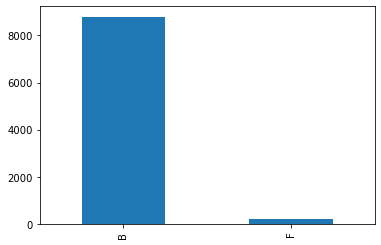

In [13]:
df.assay_type.value_counts().plot(kind='bar')

We will limit our analysis to only binding assays. 

In [14]:
df = df.query("assay_type == 'B'")
df.shape

(8791, 13)

### Aggregating Data
In order to combine rows that contain the same molecule, we will use the "groupby" function. 

In [15]:
gb = df.groupby("molregno")

We will iterate over the groups, add the name and the mean of the multiple replicates to a temporary_list. Once this is finished we will create a new dataframe with the molecule name and the average IC50. 

In [16]:
row_list = []
for k,v in gb:
    row_list.append([k,v.standard_value.mean()])
row_df = pd.DataFrame(row_list,columns=["name","standard_value"])

Let's see how many rows and columns are in our new dataframe.  Note that this is the same as the number of unique values of molregno. 

In [17]:
row_df.shape

(7382, 2)

### Examining the Data Distribution
Now we will make a plot of the distribution of IC50 values.  To do this, we will use the Seaborn Python library.

In [18]:
import seaborn as sns

First we will set a few variables to make the plots look better. 

In [19]:
sns.set(rc={'figure.figsize': (15, 12)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Now we can make the plot. 

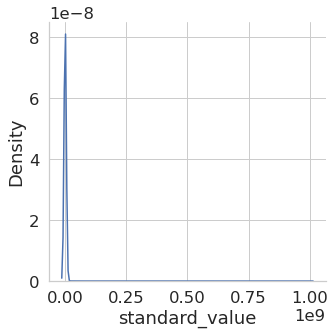

In [20]:
ax = sns.displot(row_df.standard_value,kind="kde")

Note that the plot above isn't very informative.  Most over the values are small, but there are some large values that are skewing the scale on the x-axis.   Let's plot the pIC50, which is the negative log of the IC50.  To do this, we'll first create a column containing the pIC50. 

In [21]:
row_df["pIC50"] = -np.log10(row_df.standard_value * 1e-9)

In [22]:
row_df.head()

,name,standard_value,pIC50
0,10358,16934.368,4.771231
1,1037723,130.000,6.886057
2,1038161,700.000,6.154902
3,1038163,20000.000,4.698970
4,1038164,20000.000,4.698970


Let's make another plot, this time we'll plot the pIC50 distribution. 

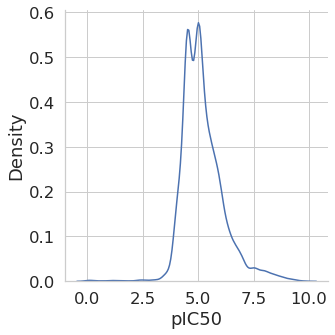

In [23]:
ax = sns.displot(row_df.pIC50,kind="kde")

### Checking For Null Values
Check the dataframe to see if we have any null values.

In [24]:
row_df.dropna().shape

(7382, 3)

In [25]:
row_df.shape

(7382, 3)

The shapes of the data frame and the dataframe without null values are the same, so we're good. 

### Sorting the Data
Sort the data by pIC50, note that the values with pIC50 approximately equal to zero (the first few rows) are almost certainly data input errors.  These compounds are reported to have IC50s of 10^9nM, which is 1M.  I seriously doubt that the compounds would even be soluble at that concentration.

In [26]:
row_df.sort_values("pIC50",ascending=True).head()

,name,standard_value,pIC50
3066,1758382,1.000000e+09,4.821637e-17
3065,1758380,1.000000e+09,4.821637e-17
3067,1758385,1.000000e+09,4.821637e-17
5531,440049,9.549926e+08,2.000000e-02
5545,440263,7.585776e+08,1.200000e-01


### Selecting High Confidence Data
Let's look at the distribution of confidence scores associated with our original dataset. 

In [27]:
df.confidence_score.value_counts()

9    8395
8     396
Name: confidence_score, dtype: int64

We will create a new dataframe with only the molecules have a confidence score of 9.

In [38]:
score_9 = df.query("confidence_score == 9")

In [39]:
score_9.shape

(8395, 13)

Let's try to add a column to the new dataframe that we created.  Note that this throws an exception because the new dataframe is just a reference to the original dataframe. 

In [40]:
score_9["extra"] = 3

<ipython-input-40-6a139fad76a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_9["extra"] = 3


What we really want to do is create a new dataframe, we can do this with the "copy" method. 

In [41]:
score_9 = df.query("confidence_score == 9").copy()

Now adding a new column works.

In [42]:
score_9['extra'] = 3

In [43]:
score_9.head()

,canonical_smiles,molregno,mol_chembl_id,standard_relation,standard_value,standard_type,standard_units,description,organism,assay_type,confidence_score,pref_name,tgt_chembl_id,extra
46,COC(=O)C1=C(C)NC(=C(C1c2ccccc2[N+](=O)[O-])C(=...,419596,CHEMBL193,=,50118.72,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,3
47,CN(CCOc1ccc(NS(=O)(=O)C)cc1)CCc2ccc(NS(=O)(=O)...,5638,CHEMBL473,=,10.00,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,3
48,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc4cccnc24)CC1,110803,CHEMBL998,=,169.82,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,3
49,Oc1ccc(CCN2CCC(CC2)Nc3nc4ccccc4n3Cc5ccc(F)cc5)cc1,91240,CHEMBL60796,=,1.00,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,3
50,Cc1[nH]cnc1CN2CCc3c(C2=O)c4ccccc4n3C,153342,CHEMBL1110,=,3235.94,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,3


Let's say that we want to create a new column with more descriptive names for the data quality.  We can do this using the "map" function. 

In [44]:
level_map = {8: 'fair', 9: 'good'}
df['confidence_level'] = df.confidence_score.map(level_map)

In [45]:
df.head()

,canonical_smiles,molregno,mol_chembl_id,standard_relation,standard_value,standard_type,standard_units,description,organism,assay_type,confidence_score,pref_name,tgt_chembl_id,confidence_level
46,COC(=O)C1=C(C)NC(=C(C1c2ccccc2[N+](=O)[O-])C(=...,419596,CHEMBL193,=,50118.72,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,good
47,CN(CCOc1ccc(NS(=O)(=O)C)cc1)CCc2ccc(NS(=O)(=O)...,5638,CHEMBL473,=,10.00,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,good
48,CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc4cccnc24)CC1,110803,CHEMBL998,=,169.82,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,good
49,Oc1ccc(CCN2CCC(CC2)Nc3nc4ccccc4n3Cc5ccc(F)cc5)cc1,91240,CHEMBL60796,=,1.00,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,good
50,Cc1[nH]cnc1CN2CCc3c(C2=O)c4ccccc4n3C,153342,CHEMBL1110,=,3235.94,IC50,nM,Inhibition of human Potassium channel HERG exp...,Homo sapiens,B,9,HERG,CHEMBL240,good


We can make a bar plot of the data quality with the descriptions on the x-axis. 

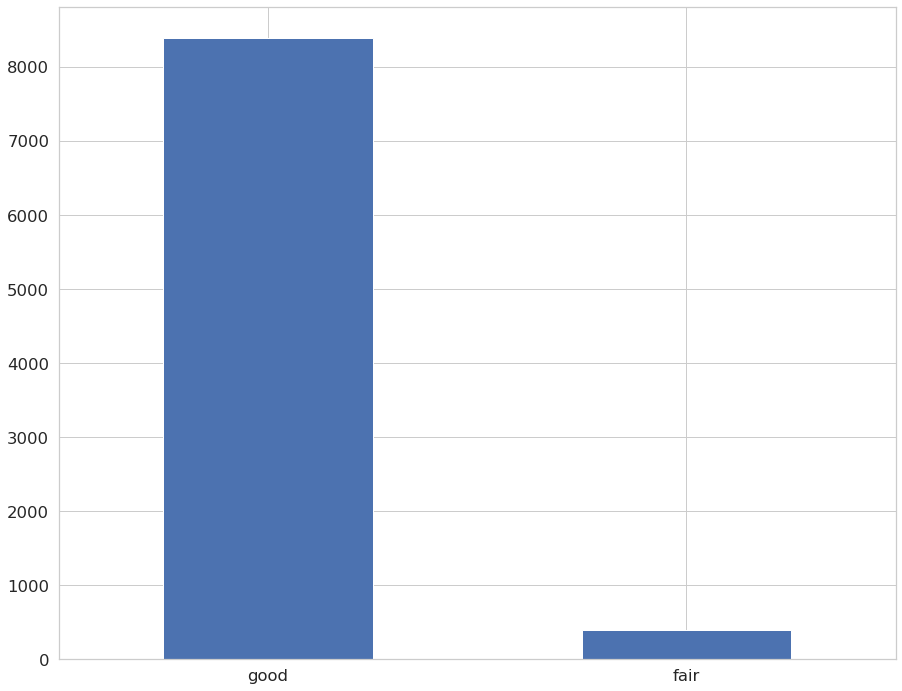

In [46]:
ax = df.confidence_level.value_counts().plot(kind="bar")
ax.tick_params(axis='x', rotation=0)

We can also make a boxplot to compare the IC50 distributions for the good quality data and the fair quality data. 

[None, Text(0.5, 0, 'Confidence Level'), Text(0, 0.5, 'IC50 (nM)')]

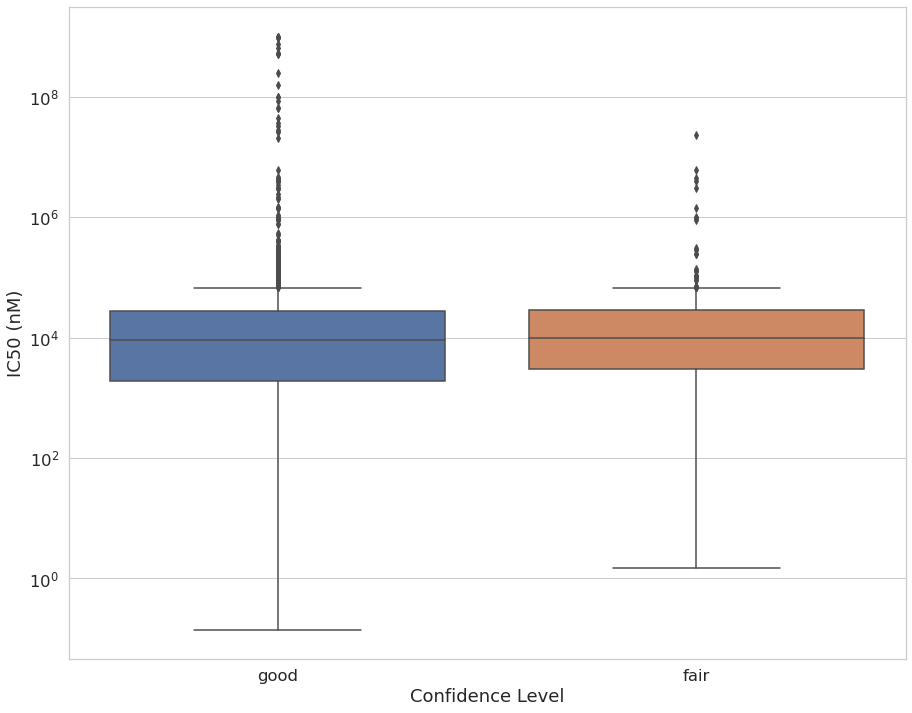

In [47]:
ax = sns.boxplot(data=df,x="confidence_level",y="standard_value")
ax.set(yscale="log",xlabel="Confidence Level",ylabel="IC50 (nM)")